# RNN for UBS Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import tensorflow as tf
from tensorflow import keras
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer

from keras.models import Sequential 
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, InputLayer, SimpleRNN
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, TimeDistributed, BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import TimeSeriesSplit


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [2]:
df = pd.read_csv("UBS_Cleaned_Date.csv")
df.date = pd.to_datetime(df.date)
df = df.set_index("date")
df = df.iloc[14:, :]
df = df.drop(["Nas_total", 'Stock_total', 'Dow_total'],axis=1) 

In [3]:
df = df.dropna()
df = df[~(df.isin([np.inf, -np.inf]).any(axis=1))] 
df.shape

(748, 197)

In [4]:
df = df.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)
target_3 = df["target_3"]

#splitting into training sets 
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
X_train = df[0:int(n*0.9)]
X_val = df[int(n*0.7):int(n*0.9)]
X_test = df[int(n*0.9):]

y_train = target_3[0:int(n*0.9)]
y_val = target_3[int(n*0.7):int(n*0.9)]
y_test = target_3[int(n*0.9):]

In [5]:
Mscaler = MinMaxScaler() # keeps binarys at zero and 1 :)

X_train = pd.DataFrame(Mscaler.fit_transform(X_train), columns = df.columns)
X_val = pd.DataFrame(Mscaler.fit_transform(X_val), columns = df.columns)
X_test = pd.DataFrame(Mscaler.fit_transform(X_test), columns = df.columns)

In [6]:
def df_to_X_y2(df, target, window_size=10): 
  X = []
  y = []
  for i in range(len(df)-window_size): # length of data frame - window_size so it does't take empty values at the end, 
    # does force you to loose the last 5 values, could fix with padding
    row = [r for r in df[i:i+window_size]] # grabs row i and all rows above within the window size length
    X.append(row) # creates 3 dimentional array, (# obseravtions, # rows in window, # features)
    label = target[i+window_size] # pulls the target variable after the window, target varible needs to be column zero in this 
    y.append(label) # returns (N,) martix of targets i+window_length time periods away
  return np.array(X), np.array(y)

In [7]:
def kbest_creator(k):
    """
    returns list of k best features and the number of efficient principle compents to use with said k features
    """
    # apply SelectKBest class to extract top 40 best features
    bestfeatures = SelectKBest(score_func=f_regression, k=k)
    best_fit = bestfeatures.fit(X_train, y_train)
    best_scores = pd.DataFrame(best_fit.scores_)
    best_columns = pd.DataFrame(df.columns)
    
    # concatenate the dataframes for better visualization
    features_score = pd.concat([best_columns, best_scores], axis=1)
    features_score.columns = ['Features', 'Score']  # naming the dataframe columns
    feats = list(features_score.nlargest(k, 'Score')['Features'])

    pca = PCA().fit(X_train[feats])
    pca_scores = np.cumsum(pca.explained_variance_ratio_) * 100
    res = next(x for x, val in enumerate(pca_scores) if val > 85)
    res = res +1
    res
    
    return feats, res


In [8]:
feats, pcs = kbest_creator(40)
# 9 compenents explain 85% 
pca_kb = PCA(n_components = pcs).fit(X_train[feats].to_numpy())
X_train_kb = pca_kb.transform(X_train[feats].to_numpy())
X_val_kb = pca_kb.transform(X_val[feats].to_numpy())
X_test_kb = pca_kb.transform(X_test[feats].to_numpy())

/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [9]:
# converting to window format, in this case 5 periods
X_train_1, train_5w = df_to_X_y2(X_train_kb,y_train)
X_val_1, val_5w = df_to_X_y2(X_val_kb, y_val)
X_test_1, test_5w = df_to_X_y2(X_test_kb,y_test) 


In [10]:
print(X_train_1.shape, train_5w.shape)
print(X_val_1.shape, val_5w.shape)
print(X_test_1.shape, test_5w.shape)

(663, 10, 10) (663,)
(140, 10, 10) (140,)
(65, 10, 10) (65,)


# Models Using PCA of 40 K Best

In [11]:
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid', 
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))


In [12]:
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 8)             608       
                                                                 
 batch_normalization (BatchN  (None, 10, 8)            32        
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 10, 8)             544       
                                                                 
 batch_normalization_1 (Batc  (None, 10, 8)            32        
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 8)                 544       
                                                                 
 batch_normalization_2 (Batc  (None, 8)                3

In [13]:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation

history = model.fit(X_train_1, train_5w,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_val_1, val_5w))

Epoch 1/100
14/14 [==============================] - 13s 135ms/step - loss: 2.6366 - accuracy: 0.5128 - val_loss: 2.4632 - val_accuracy: 0.5143
Epoch 2/100
14/14 [==============================] - 0s 32ms/step - loss: 2.4342 - accuracy: 0.5204 - val_loss: 2.3186 - val_accuracy: 0.5214
Epoch 3/100
14/14 [==============================] - 0s 34ms/step - loss: 2.2661 - accuracy: 0.5430 - val_loss: 2.1840 - val_accuracy: 0.5143
Epoch 4/100
14/14 [==============================] - 1s 37ms/step - loss: 2.1269 - accuracy: 0.5385 - val_loss: 2.0600 - val_accuracy: 0.5071
Epoch 5/100
14/14 [==============================] - 0s 32ms/step - loss: 2.0040 - accuracy: 0.5747 - val_loss: 1.9466 - val_accuracy: 0.5071
Epoch 6/100
14/14 [==============================] - 0s 30ms/step - loss: 1.8899 - accuracy: 0.5837 - val_loss: 1.8439 - val_accuracy: 0.5071
Epoch 7/100
14/14 [==============================] - 0s 29ms/step - loss: 1.7865 - accuracy: 0.5762 - val_loss: 1.7504 - val_accuracy: 0.5000
Epoc

In [14]:
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')


-----------------------------------------------------------------
train accuracy = 67.1192%
test accuracy = 46.1538%
test error = 35 out of 65 examples


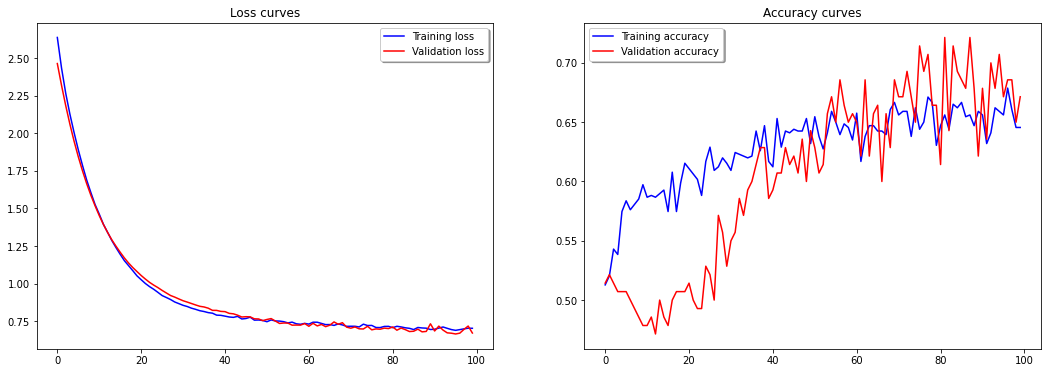

In [15]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [16]:
y_hat = model.predict(X_test_1, batch_size=50, verbose=1)
#score = sum(y_hat == y_test) / len(y_test)
#print(f'Prediction accuracy = {score*100}%')
index = pd.date_range(start='2017-01-02', end='2018-06-19', freq='B')
for i in range(y_hat.shape[0]):
    print(index[i], y_hat[i], test_5w[i])

2/2 [==============================] - 1s 8ms/step
2017-01-02 00:00:00 [0.79954416] 1
2017-01-03 00:00:00 [0.63565904] 1
2017-01-04 00:00:00 [0.3805544] 1
2017-01-05 00:00:00 [0.25177002] 0
2017-01-06 00:00:00 [0.15970427] 0
2017-01-09 00:00:00 [0.16639245] 1
2017-01-10 00:00:00 [0.17841834] 1
2017-01-11 00:00:00 [0.14532945] 0
2017-01-12 00:00:00 [0.33571413] 1
2017-01-13 00:00:00 [0.48756525] 1
2017-01-16 00:00:00 [0.4374034] 0
2017-01-17 00:00:00 [0.27436027] 1
2017-01-18 00:00:00 [0.27651188] 1
2017-01-19 00:00:00 [0.16473636] 0
2017-01-20 00:00:00 [0.19490665] 1
2017-01-23 00:00:00 [0.2643879] 0
2017-01-24 00:00:00 [0.17826086] 0
2017-01-25 00:00:00 [0.30941528] 0
2017-01-26 00:00:00 [0.22597456] 0
2017-01-27 00:00:00 [0.23358041] 0
2017-01-30 00:00:00 [0.3168319] 1
2017-01-31 00:00:00 [0.39585602] 0
2017-02-01 00:00:00 [0.6102499] 1
2017-02-02 00:00:00 [0.60361767] 1
2017-02-03 00:00:00 [0.31752217] 1
2017-02-06 00:00:00 [0.16871154] 1
2017-02-07 00:00:00 [0.16865486] 0
2017-02-0

[Text(0, 0.5, 'True: 0'), Text(0, 1.5, 'True: 1')]

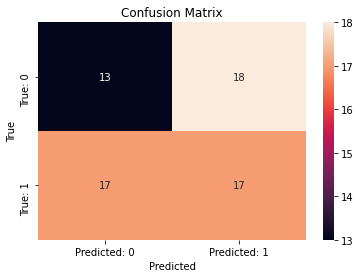

In [17]:
# Display confusion matrix results
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
predicted = model.predict(X_test_1)
predicted = (predicted > 0.5)

confusion = confusion_matrix(test_5w, predicted)

sns.heatmap(confusion, annot=True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["Predicted: 0", "Predicted: 1"])
ax.yaxis.set_ticklabels(["True: 0", "True: 1"])


In [18]:
# model2
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modeling:
LAYERS = [4, 4, 4, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model2
model2 = Sequential()
model2.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model2.add(BatchNormalization())
model2.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid', 
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model2.add(BatchNormalization())
model2.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model2.add(BatchNormalization())
model2.add(Dense(12, activation='relu'))
model2.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [19]:
model2.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 4)             240       
                                                                 
 batch_normalization_3 (Batc  (None, 10, 4)            16        
 hNormalization)                                                 
                                                                 
 lstm_4 (LSTM)               (None, 10, 4)             144       
                                                                 
 batch_normalization_4 (Batc  (None, 10, 4)            16        
 hNormalization)                                                 
                                                                 
 lstm_5 (LSTM)               (None, 4)                 144       
                                                                 
 batch_normalization_5 (Batc  (None, 4)               

In [20]:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(patience=7)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation

history = model2.fit(X_train_1, train_5w,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_val_1, val_5w), callbacks=[early_stop])

Epoch 1/100
14/14 [==============================] - 13s 118ms/step - loss: 1.8292 - accuracy: 0.4796 - val_loss: 1.7365 - val_accuracy: 0.4643
Epoch 2/100
14/14 [==============================] - 0s 33ms/step - loss: 1.7344 - accuracy: 0.4796 - val_loss: 1.6641 - val_accuracy: 0.4357
Epoch 3/100
14/14 [==============================] - 1s 40ms/step - loss: 1.6565 - accuracy: 0.4751 - val_loss: 1.5959 - val_accuracy: 0.4500
Epoch 4/100
14/14 [==============================] - 0s 34ms/step - loss: 1.5802 - accuracy: 0.4811 - val_loss: 1.5321 - val_accuracy: 0.4571
Epoch 5/100
14/14 [==============================] - 1s 38ms/step - loss: 1.5143 - accuracy: 0.4947 - val_loss: 1.4722 - val_accuracy: 0.4643
Epoch 6/100
14/14 [==============================] - 0s 35ms/step - loss: 1.4522 - accuracy: 0.5098 - val_loss: 1.4163 - val_accuracy: 0.4643
Epoch 7/100
14/14 [==============================] - 1s 36ms/step - loss: 1.3963 - accuracy: 0.4962 - val_loss: 1.3638 - val_accuracy: 0.4571
Epoc

In [21]:
train_loss, train_acc = model2.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model2.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')


-----------------------------------------------------------------
train accuracy = 58.5219%
test accuracy = 47.6923%
test error = 34 out of 65 examples


In [22]:
# model3
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modeling:
LAYERS = [4, 4, 4, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model3
model3 = Sequential()

model3.add(LSTM(units=LAYERS[2],input_shape=(n_steps, n_features),
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model3.add(BatchNormalization())
model3.add(Dense(12, activation='relu'))
model3.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [23]:
model3.compile(loss='binary_crossentropy',
              metrics=['BinaryAccuracy'],
              optimizer="adam")
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 4)                 240       
                                                                 
 batch_normalization_6 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 12)                60        
                                                                 
 dense_4 (Dense)             (None, 1)                 13        
                                                                 
Total params: 329
Trainable params: 321
Non-trainable params: 8
_________________________________________________________________
None


In [24]:
history = model3.fit(X_train_1, train_5w,
                    epochs=100,
                    validation_data=(X_val_1, val_5w), callbacks=[early_stop])

Epoch 1/100
21/21 [==============================] - 4s 34ms/step - loss: 1.1881 - binary_accuracy: 0.4947 - val_loss: 1.1171 - val_binary_accuracy: 0.4786
Epoch 2/100
21/21 [==============================] - 0s 15ms/step - loss: 1.1263 - binary_accuracy: 0.4992 - val_loss: 1.0710 - val_binary_accuracy: 0.4857
Epoch 3/100
21/21 [==============================] - 0s 12ms/step - loss: 1.0730 - binary_accuracy: 0.5053 - val_loss: 1.0298 - val_binary_accuracy: 0.4643
Epoch 4/100
21/21 [==============================] - 0s 14ms/step - loss: 1.0263 - binary_accuracy: 0.4887 - val_loss: 0.9926 - val_binary_accuracy: 0.4571
Epoch 5/100
21/21 [==============================] - 0s 11ms/step - loss: 0.9849 - binary_accuracy: 0.5219 - val_loss: 0.9584 - val_binary_accuracy: 0.4571
Epoch 6/100
21/21 [==============================] - 0s 12ms/step - loss: 0.9498 - binary_accuracy: 0.5173 - val_loss: 0.9284 - val_binary_accuracy: 0.4571
Epoch 7/100
21/21 [==============================] - 0s 11ms/ste

In [25]:
train_loss, train_acc = model3.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model3.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 57.4661%
test accuracy = 46.1538%
test error = 35 out of 65 examples


In [26]:
# model4
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modeling:
LAYERS = [4, 4, 4, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model4
model4 = Sequential()

model4.add(LSTM(units=LAYERS[2],input_shape=(n_steps, n_features),
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model4.add(BatchNormalization())
model4.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [27]:
model4.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 4)                 240       
                                                                 
 batch_normalization_7 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 261
Trainable params: 253
Non-trainable params: 8
_________________________________________________________________
None


In [28]:
history = model4.fit(X_train_1, train_5w,
                    epochs=100,
                    validation_data=(X_val_1, val_5w), callbacks=[early_stop])

Epoch 1/100
21/21 [==============================] - 3s 27ms/step - loss: 1.3142 - accuracy: 0.5309 - val_loss: 1.0917 - val_accuracy: 0.5714
Epoch 2/100
21/21 [==============================] - 0s 11ms/step - loss: 1.2392 - accuracy: 0.5354 - val_loss: 1.0513 - val_accuracy: 0.5786
Epoch 3/100
21/21 [==============================] - 0s 10ms/step - loss: 1.1738 - accuracy: 0.5339 - val_loss: 1.0137 - val_accuracy: 0.5857
Epoch 4/100
21/21 [==============================] - 0s 11ms/step - loss: 1.1180 - accuracy: 0.5279 - val_loss: 0.9805 - val_accuracy: 0.5857
Epoch 5/100
21/21 [==============================] - 0s 10ms/step - loss: 1.0649 - accuracy: 0.5475 - val_loss: 0.9503 - val_accuracy: 0.5857
Epoch 6/100
21/21 [==============================] - 0s 11ms/step - loss: 1.0231 - accuracy: 0.5370 - val_loss: 0.9232 - val_accuracy: 0.5857
Epoch 7/100
21/21 [==============================] - 0s 11ms/step - loss: 0.9832 - accuracy: 0.5354 - val_loss: 0.8988 - val_accuracy: 0.5929
Epoch 

In [29]:
train_loss, train_acc = model4.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model4.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 56.8627%
test accuracy = 46.1538%
test error = 35 out of 65 examples


# Trying With PCA of 10 k Best Variables 

In [30]:
feats, pcs = kbest_creator(10)
# 9 compenents explain 85% 
pca_kb = PCA(n_components = pcs).fit(X_train[feats].to_numpy())
X_train_kb = pca_kb.transform(X_train[feats].to_numpy())
X_val_kb = pca_kb.transform(X_val[feats].to_numpy())
X_test_kb = pca_kb.transform(X_test[feats].to_numpy())

/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [31]:
# converting to window format, in this case 5 periods
X_train_2, train_5w = df_to_X_y2(X_train_kb,y_train)
X_val_2, val_5w = df_to_X_y2(X_val_kb, y_val)
X_test_2, test_5w = df_to_X_y2(X_test_kb,y_test) 


In [32]:
print(X_train_2.shape, train_5w.shape)
print(X_val_2.shape, val_5w.shape)
print(X_test_2.shape, test_5w.shape)

(663, 10, 3) (663,)
(140, 10, 3) (140,)
(65, 10, 3) (65,)


In [33]:
n_steps = X_train_2.shape[1]
n_features = X_train_2.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_2.shape[0]           # number of training examples (2D)
M_TEST = X_test_2.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_2.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid', 
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))


In [34]:
model.compile(loss='binary_crossentropy',
              metrics=['BinaryAccuracy'],
              optimizer="adam")
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 10, 8)             384       
                                                                 
 batch_normalization_8 (Batc  (None, 10, 8)            32        
 hNormalization)                                                 
                                                                 
 lstm_9 (LSTM)               (None, 10, 8)             544       
                                                                 
 batch_normalization_9 (Batc  (None, 10, 8)            32        
 hNormalization)                                                 
                                                                 
 lstm_10 (LSTM)              (None, 8)                 544       
                                                                 
 batch_normalization_10 (Bat  (None, 8)               

In [35]:
history = model.fit(X_train_2, train_5w,
                    epochs=100,
                    validation_data=(X_val_2, val_5w), callbacks=[early_stop])

Epoch 1/100
21/21 [==============================] - 7s 76ms/step - loss: 2.4869 - binary_accuracy: 0.5023 - val_loss: 2.2097 - val_binary_accuracy: 0.5571
Epoch 2/100
21/21 [==============================] - 0s 20ms/step - loss: 2.1752 - binary_accuracy: 0.5113 - val_loss: 2.0358 - val_binary_accuracy: 0.5429
Epoch 3/100
21/21 [==============================] - 0s 20ms/step - loss: 1.9823 - binary_accuracy: 0.5249 - val_loss: 1.8784 - val_binary_accuracy: 0.5429
Epoch 4/100
21/21 [==============================] - 0s 18ms/step - loss: 1.8192 - binary_accuracy: 0.5309 - val_loss: 1.7385 - val_binary_accuracy: 0.5357
Epoch 5/100
21/21 [==============================] - 0s 19ms/step - loss: 1.6807 - binary_accuracy: 0.5249 - val_loss: 1.6150 - val_binary_accuracy: 0.5214
Epoch 6/100
21/21 [==============================] - 0s 20ms/step - loss: 1.5630 - binary_accuracy: 0.5294 - val_loss: 1.5074 - val_binary_accuracy: 0.5214
Epoch 7/100
21/21 [==============================] - 0s 21ms/ste

In [36]:
train_loss, train_acc = model.evaluate(X_train_2, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test_2, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 53.6953%
test accuracy = 60.0%
test error = 26 out of 65 examples


In [37]:
n_steps = X_train_2.shape[1]
n_features = X_train_2.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [4, 4, 4, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_2.shape[0]           # number of training examples (2D)
M_TEST = X_test_2.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_2.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model2 = Sequential()
model2.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model2.add(BatchNormalization())
model2.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid', 
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model2.add(BatchNormalization())
model2.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model2.add(BatchNormalization())
model2.add(Dense(units=LAYERS[3], activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              metrics=['BinaryAccuracy'],
              optimizer="adam")
print(model2.summary())

history = model2.fit(X_train_2, train_5w,
                    epochs=100,
                    validation_data=(X_val_2, val_5w), callbacks=[early_stop])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 10, 4)             128       
                                                                 
 batch_normalization_11 (Bat  (None, 10, 4)            16        
 chNormalization)                                                
                                                                 
 lstm_12 (LSTM)              (None, 10, 4)             144       
                                                                 
 batch_normalization_12 (Bat  (None, 10, 4)            16        
 chNormalization)                                                
                                                                 
 lstm_13 (LSTM)              (None, 4)                 144       
                                                                 
 batch_normalization_13 (Bat  (None, 4)               

In [38]:
train_loss, train_acc = model2.evaluate(X_train_2, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model2.evaluate(X_test_2, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 52.9412%
test accuracy = 49.2308%
test error = 33 out of 65 examples


In [39]:
n_steps = X_train_2.shape[1]
n_features = X_train_2.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [32, 32, 32, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_2.shape[0]           # number of training examples (2D)
M_TEST = X_test_2.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_2.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model3 = Sequential()
model3.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model3.add(BatchNormalization())
model3.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid', 
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model3.add(BatchNormalization())
model3.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model3.add(BatchNormalization())
model3.add(Dense(units=LAYERS[3], activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
              metrics=['BinaryAccuracy'],
              optimizer="adam")
print(model3.summary())

history = model3.fit(X_train_2, train_5w,
                    epochs=100,
                    validation_data=(X_val_2, val_5w), callbacks=[early_stop])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 10, 32)            4608      
                                                                 
 batch_normalization_14 (Bat  (None, 10, 32)           128       
 chNormalization)                                                
                                                                 
 lstm_15 (LSTM)              (None, 10, 32)            8320      
                                                                 
 batch_normalization_15 (Bat  (None, 10, 32)           128       
 chNormalization)                                                
                                                                 
 lstm_16 (LSTM)              (None, 32)                8320      
                                                                 
 batch_normalization_16 (Bat  (None, 32)              

In [40]:
train_loss, train_acc = model3.evaluate(X_train_2, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model3.evaluate(X_test_2, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 56.4103%
test accuracy = 49.2308%
test error = 33 out of 65 examples


In [41]:
n_steps = X_train_2.shape[1]
n_features = X_train_2.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [4, 8, 4, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_2.shape[0]           # number of training examples (2D)
M_TEST = X_test_2.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_2.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model4 = Sequential()
model4.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model4.add(BatchNormalization())

model4.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model4.add(BatchNormalization())
model4.add(Dense(units=LAYERS[3], activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              metrics=['BinaryAccuracy'],
              optimizer="adam")
print(model4.summary())

history = model4.fit(X_train_2, train_5w,
                    epochs=100,
                    validation_data=(X_val_2, val_5w), callbacks=[early_stop])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 10, 4)             128       
                                                                 
 batch_normalization_17 (Bat  (None, 10, 4)            16        
 chNormalization)                                                
                                                                 
 lstm_18 (LSTM)              (None, 4)                 144       
                                                                 
 batch_normalization_18 (Bat  (None, 4)                16        
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 309
Trainable params: 293
Non-trainable 

In [42]:
train_loss, train_acc = model4.evaluate(X_train_2, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model4.evaluate(X_test_2, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 53.5445%
test accuracy = 36.9231%
test error = 41 out of 65 examples


In [43]:
n_steps = X_train_2.shape[1]
n_features = X_train_2.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [4, 4, 4, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_2.shape[0]           # number of training examples (2D)
M_TEST = X_test_2.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_2.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model5 = Sequential()

model5.add(LSTM(units=LAYERS[2], input_shape=(n_steps, n_features),
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model5.add(BatchNormalization())
model5.add(Dense(units=LAYERS[3], activation='sigmoid'))

model5.compile(loss='binary_crossentropy',
              metrics=['BinaryAccuracy'],
              optimizer="adam")
print(model5.summary())

history = model5.fit(X_train_2, train_5w,
                    epochs=100,
                    validation_data=(X_val_2, val_5w), callbacks=[early_stop])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 4)                 128       
                                                                 
 batch_normalization_19 (Bat  (None, 4)                16        
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 1)                 5         
                                                                 
Total params: 149
Trainable params: 141
Non-trainable params: 8
_________________________________________________________________
None
Epoch 1/100
21/21 [==============================] - 3s 27ms/step - loss: 0.9917 - binary_accuracy: 0.4932 - val_loss: 0.9523 - val_binary_accuracy: 0.5286
Epoch 2/100
21/21 [==============================] - 0s 12ms/step - loss: 0.9563 - binary_acc

In [44]:
train_loss, train_acc = model5.evaluate(X_train_2, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model5.evaluate(X_test_2, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 52.9412%
test accuracy = 52.3077%
test error = 31 out of 65 examples


In [45]:
n_steps = X_train_2.shape[1]
n_features = X_train_2.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [32, 32, 32, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_2.shape[0]           # number of training examples (2D)
M_TEST = X_test_2.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_2.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model6 = Sequential()

model6.add(LSTM(units=LAYERS[2], input_shape=(n_steps, n_features),
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model6.add(BatchNormalization())
model6.add(Dense(units=LAYERS[3], activation='sigmoid'))

model6.compile(loss='binary_crossentropy',
              metrics=['BinaryAccuracy'],
              optimizer="adam")
print(model6.summary())

history = model6.fit(X_train_2, train_5w,
                    epochs=100,
                    validation_data=(X_val_2, val_5w), callbacks=[early_stop])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 32)                4608      
                                                                 
 batch_normalization_20 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,769
Trainable params: 4,705
Non-trainable params: 64
_________________________________________________________________
None
Epoch 1/100
21/21 [==============================] - 3s 28ms/step - loss: 1.7200 - binary_accuracy: 0.5113 - val_loss: 1.5147 - val_binary_accuracy: 0.5357
Epoch 2/100
21/21 [==============================] - 0s 10ms/step - loss: 1.4065 - binar

In [46]:
train_loss, train_acc = model6.evaluate(X_train_2, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model6.evaluate(X_test_2, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 52.7903%
test accuracy = 52.3077%
test error = 31 out of 65 examples
